# Import Neccessary Librarys

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Bidirectional
from keras import Sequential

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Load Dataset

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Next Word Prediction/medium_data.csv")

In [8]:
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            6508 non-null   int64 
 1   url           6508 non-null   object
 2   title         6508 non-null   object
 3   subtitle      3479 non-null   object
 4   image         6361 non-null   object
 5   claps         6508 non-null   int64 
 6   responses     6508 non-null   object
 7   reading_time  6508 non-null   int64 
 8   publication   6508 non-null   object
 9   date          6508 non-null   object
dtypes: int64(3), object(7)
memory usage: 508.6+ KB


In [10]:
df.isnull().sum()

id                 0
url                0
title              0
subtitle        3029
image            147
claps              0
responses          0
reading_time       0
publication        0
date               0
dtype: int64

# Use title and subtitle column

In [11]:
df = df[["title", "subtitle"]]

In [12]:
df.head()

,title,subtitle
0,A Beginner’s Guide to Word Embedding with Gens...,NaN
1,Hands-on Graph Neural Networks with PyTorch & ...,NaN
2,How to Use ggplot2 in Python,A Grammar of Graphics for Python
3,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…
4,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…


In [13]:
df = pd.concat([df["title"], df["subtitle"]], ignore_index=True)
df.head()

0    A Beginner’s Guide to Word Embedding with Gens...
1    Hands-on Graph Neural Networks with PyTorch & ...
2                         How to Use ggplot2 in Python
3    Databricks: How to Save Files in CSV on Your L...
4    A Step-by-Step Implementation of Gradient Desc...
dtype: object

# Preprocess the Dataset

In [14]:
df.isnull().sum()

3029

In [15]:
df.dropna(inplace=True)

In [16]:
df.isnull().sum()

0

In [17]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean(text):
  words = word_tokenize(text.lower())
  words = [lemmatizer.lemmatize(word, pos="v") for word in words if word and len(word) > 1]
  return ' '.join(words)

In [18]:
df = df.apply(lambda x: clean(x))

In [19]:
df.head()

0    beginner guide to word embed with gensim word2...
1    hands-on graph neural network with pytorch pyt...
2                         how to use ggplot2 in python
3    databricks how to save file in csv on your loc...
4    step-by-step implementation of gradient descen...
dtype: object

# max_len and vocab_size

In [20]:
max_len = max(len(line) for line in df)
max_len

340

In [ ]:
tokenizer = Tokenizer(oov_token="<nan>")
tokenizer.fit_on_texts(df)
tokenizer.word_index

In [22]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8859

# Data Generator Function

In [23]:
def data_generator(df, tokenizer, max_len, vocab_size, batch_size):
  X, y = list(), list()
  n = 0
  while True:
    for line in df:
      n+=1
      seq = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], padding="post", maxlen=max_len)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

        X.append(in_seq)
        y.append(out_seq)

      if n == batch_size:
        yield np.array(X), np.array(y)
        X, y = list(), list()
        n = 0

# Model Building

In [24]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len),
    Bidirectional(LSTM(150)),
    Dense(vocab_size, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 340, 100)          885900    
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8859)              2666559   
                                                                 
Total params: 3853659 (14.70 MB)
Trainable params: 3853659 (14.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [71]:
epochs = 20
batch_size = 32
steps_per_epoch = len(df) // batch_size
history = []

for i in range(1, epochs+1):
    print(f"Epoch {i}")
    data = data_generator(df, tokenizer, max_len, vocab_size, batch_size)
    hist = model.fit(data, steps_per_epoch=steps_per_epoch, epochs=1)
    history.append(hist)

Epoch 1
312/312 [==============================] - 29s 92ms/step - loss: 0.7743 - accuracy: 0.8351
Epoch 2
312/312 [==============================] - 29s 94ms/step - loss: 0.7788 - accuracy: 0.8330
Epoch 3
312/312 [==============================] - 29s 93ms/step - loss: 0.8902 - accuracy: 0.8008
Epoch 4
312/312 [==============================] - 29s 93ms/step - loss: 0.8385 - accuracy: 0.8149
Epoch 5
312/312 [==============================] - 29s 92ms/step - loss: 0.7952 - accuracy: 0.8255
Epoch 6
312/312 [==============================] - 29s 93ms/step - loss: 0.7688 - accuracy: 0.8327
Epoch 7
312/312 [==============================] - 29s 93ms/step - loss: 0.8505 - accuracy: 0.8108
Epoch 8
312/312 [==============================] - 29s 92ms/step - loss: 0.8578 - accuracy: 0.8077
Epoch 9
312/312 [==============================] - 29s 93ms/step - loss: 0.7883 - accuracy: 0.8262
Epoch 10
312/312 [==============================] - 29s 92ms/step - loss: 0.7553 - accuracy: 0.8340
Epoch 11


# Save

In [72]:
model.save("/content/drive/MyDrive/Colab Notebooks/Next Word Prediction/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
with open("/content/drive/MyDrive/Colab Notebooks/Next Word Prediction/tokenizer.pkl", "wb") as f:
  pickle.dump(tokenizer, f)
with open("/content/drive/MyDrive/Colab Notebooks/Next Word Prediction/History.pkl", "wb") as f:
  pickle.dump(history, f)

# Loss vs Accuracy

In [75]:
with open("/content/drive/MyDrive/Colab Notebooks/Next Word Prediction/History.pkl", "rb") as f:
  history = pickle.load(f)

In [76]:
loss = []
accuracy = []
for hist in history:
  loss.append(hist.history['loss'])
  accuracy.append(hist.history['accuracy'])

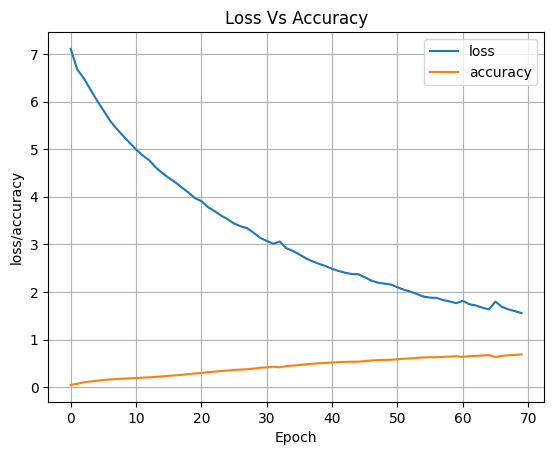

In [77]:
plt.plot([i for i in range(len(loss))], loss, label="loss"),
plt.plot([i for i in range(len(accuracy))], accuracy, label="accuracy"),
plt.title("Loss Vs Accuracy"),
plt.xlabel("Epoch"),
plt.ylabel("loss/accuracy")
plt.grid(),
plt.legend(),
plt.show()

# Prediction

In [78]:
def integer_to_text(tokenizer, label):
  for idx, val in tokenizer.word_index.items():
    if val == label:
      return idx
  return None

In [79]:
import numpy as np

def generate_next_word(text, next_words):
    for _ in range(next_words):
        seq = tokenizer.texts_to_sequences([text])[0]
        seq = pad_sequences([seq], padding="post", maxlen=max_len)[0]
        # Reshape the sequence to add a batch dimension
        seq = np.reshape(seq, (1, len(seq), 1))  # Assuming feature_dim is 1
        label_probabilities = model.predict(seq, verbose=False).flatten()

        # Get the indices of the top 3 probabilities
        top_3_indices = np.argsort(label_probabilities)[-3:][::-1]

        # Randomly select one of the top 3 indices
        selected_index = np.random.choice(top_3_indices)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == selected_index:
                output_word = word
                break
        text += " " + output_word
    return text

In [85]:
generate_next_word("how to build your", 10)

'how to build your work from work quick ethic into and more away market'